# Scheme statistics

In [5]:
import os
from datetime import datetime
import glob
import pandas as pd
import time

In [6]:
# Load Forsage data
print("loading traces")
# from_traces = pd.read_csv('../../forsage_data_temp/from_forsage_traces.csv')
# to_traces = pd.read_csv('../../forsage_data_temp/to_forsage_traces.csv')
print("loading txs")
to_txs = pd.read_csv('../../forsage_data_temp/to_forsage_txs.csv')
print("loading blocktimestamp")
block_timestamp = pd.read_csv('../../forsage_data_temp/block_numbers.csv.gz')
print("cleaning timestamp")
block_timestamp['timestamp_date'] = pd.to_datetime(block_timestamp['timestamp'], format="%Y-%m-%d %H:%M:%S")

loading traces
loading txs
loading blocktimestamp
cleaning timestamp


In [7]:
# Load ethereum price downloaded from coindesk
eth_price = pd.read_csv('../../forsage_data_temp/ETH_USD_2015-08-09_2021-01-13-CoinDesk.csv.gz')
eth_price['Date'] = eth_price['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
print("Calculating median")
eth_price['median']=eth_price.apply(lambda row: (row['24h High (USD)']+row['24h Low (USD)'])/2, axis=1)

Calculating median


### Generating data for table, 

Contract - Total txs, unique addresses, total coins, total usd, launch date, address

In [8]:
## Clean data for matrix
# only keep accepted txs
to_txs=to_txs[to_txs['receipt_status']==1]
# drop useless columns
to_txs.drop(columns=['gas','gas_price','receipt_gas_used','receipt_status','transaction_index'], inplace=True)
# Convert date
to_txs['Date'] = to_txs['block_timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S+00:00').date())
# Convert to ETH
to_txs['value_eth'] = to_txs['value'].apply(lambda x: int(x)/1e18)
# Drop blocks
to_txs.drop(columns=['block_number'], inplace=True)
# Remove txs past cut-off date
to_txs = to_txs[to_txs['Date']<datetime(2021,1,14,0,0,0).date()]
# Groupby Date
gp = to_txs.groupby("Date")
# Total all days
gpx = gp.sum().reset_index()
# Finding the highest days
highest_day = {}
for i, row in gpx.iterrows():
    if row['Date'] in eth_price['Date'].values:
        val = eth_price[eth_price['Date']==row['Date']]['median'].values[0]
        total = row['value_eth']*val
        highest_day[row['Date']] = total
# How much did all the main contracts generate in USD
print("ETH Matrix")
print("# of TXs sent: %i" % len(to_txs))
print("Total Eth %.8f" % sum(to_txs['value_eth']))
print("USD value %.8f" % sum(highest_day.values()))
print("Highest day USD")
print(list(dict(sorted(highest_day.items(), key=lambda item: item[1], reverse=True)))[0])
print(highest_day[list(dict(sorted(highest_day.items(), key=lambda item: item[1], reverse=True)))[0]])
print("Average per day %i" % (len(to_txs)/len(highest_day)))

ETH Matrix
# of TXs sent: 3266722
Total Eth 721924.45000166
USD value 225998105.38630983
Highest day USD
2020-08-01
3793130.8356227824
Average per day 9387


In [9]:
# Same for eth xgold
xgold_to_txs = pd.read_csv('../../forsage_data_temp/xgold_to_forsage_txs.csv.gz')
# Filter
xgold_to_txs=xgold_to_txs[xgold_to_txs['receipt_status']==1]
# Drop useless
xgold_to_txs = xgold_to_txs.drop(columns=['to_address', 'from_address', 'hash', 'gas','gas_price','receipt_gas_used','receipt_status','transaction_index'])
# convert date
xgold_to_txs['Date'] = xgold_to_txs['block_timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S+00:00').date())
# convert eth value
xgold_to_txs['value_eth'] = xgold_to_txs['value'].apply(lambda x: int(x)/1e18)
# drop by time
xgold_to_txs=xgold_to_txs[xgold_to_txs['block_number']<11649878]
# Keep only two
xgold_to_txs.drop(columns=['block_number', 'value'], inplace=True)
# Group by date
xgold_gp = xgold_to_txs.groupby("Date")
xgold_gpx = xgold_gp.sum().reset_index()
# find highest day
xgold_highest_day = {}
for i, row in xgold_gpx.iterrows():
    if row['Date'] in eth_price['Date'].values:
        val = eth_price[eth_price['Date']==row['Date']]['median'].values[0]
        total = row['value_eth']*val
        xgold_highest_day[row['Date']] = total
# Print results
print("ETH xGold")
print("# of TXs sent: %i" % len(xgold_to_txs))
print("Total Eth %.8f" % sum(xgold_to_txs['value_eth']))
print("USD value %.8f" % sum(xgold_highest_day.values()))
print("Highest day USD")
print(list(dict(sorted(xgold_highest_day.items(), key=lambda item: item[1], reverse=True)))[0])
print(xgold_highest_day[list(dict(sorted(xgold_highest_day.items(), key=lambda item: item[1], reverse=True)))[0]])
print("Average per day %i" % (len(xgold_to_txs)/len(xgold_highest_day)))

ETH xGold
# of TXs sent: 37562
Total Eth 8898.15000001
USD value 9037769.17294407
Highest day USD
2021-01-03
2466425.5923868893
Average per day 3414


In [12]:
# Same for tron 
# Load the tron price
tron_price = pd.read_csv("../../forsage_data_temp/TRX_USD_2020-01-21_2021-01-20-CoinDesk.csv")
tron_price['median']=tron_price.apply(lambda row: (row['24h Open (USD)']+row['Closing Price (USD)'])/2, axis=1)
tron_price['Date'] = tron_price['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
# Load df
tron_df = pd.read_csv("../../forsage_data_temp/tron_txs.csv.gz")
# Convert timestamps
tron_df['timestamp']  = tron_df.apply(lambda row: int(str(row.timestamp)[:-3]), axis=1)
# Convert dates
tron_df['Date'] = tron_df.apply(lambda row: datetime.fromtimestamp(row.timestamp).date(), axis=1)
# Convert values
tron_df['value']=tron_df.apply(lambda row: row['amount']/1e6, axis=1)
# count stuff
tron_users_count = len(set(list(tron_df[tron_df['type']=='standard']['from_address'])))
tron_users_scam_count = len(set(list(tron_df[tron_df['type']=='scam']['from_address'])))
tron_users_xgold_count = len(set(list(tron_df[tron_df['type']=='xgold']['from_address'])))
# Simply dataframe
tron_df=tron_df[['value', 'Date', 'type']]
# Filter into different dataframes
tron_scam = tron_df[tron_df['type']=='scam']
tron_xgold=tron_df[tron_df['type']=='xgold']
tron_df = tron_df[tron_df['type']=='standard']

In [13]:
# Tron Matrix 
tron_df_gp = tron_df.groupby("Date")
tron_df_gpx = tron_df_gp.sum().reset_index()
tron_gpx_highest_day = {}
for i, row in tron_df_gpx.iterrows():
    if row['Date'] in tron_price['Date'].values:
        val = tron_price[tron_price['Date']==row['Date']]['median'].values[0]
        total = row['value']*val
        tron_gpx_highest_day[row['Date']] = total
print("Tron Matrix")
print("# of sent: %i" % len(tron_df))
print("# of users: %i" % tron_users_count)
print("Total TRX %.8f" % sum(tron_df['value']))
print("USD value %.8f" % sum(tron_gpx_highest_day.values()))
print("Highest day USD")
print(list(dict(sorted(tron_gpx_highest_day.items(), key=lambda item: item[1], reverse=True)))[0])
print(tron_gpx_highest_day[list(dict(sorted(tron_gpx_highest_day.items(), key=lambda item: item[1], reverse=True)))[0]])
print("Average per day %i" % (len(tron_df)/len(tron_gpx_highest_day)))

Tron Matrix
# of sent: 1194124
# of users: 342221
Total TRX 1094548444.69194651
USD value 31501351.84977436
Highest day USD
2020-09-06
2434027.1616682317
Average per day 8845


In [14]:
tron_xgold_df_gp = tron_xgold.groupby("Date")
tron_xgold_df_gpx = tron_xgold_df_gp.sum().reset_index()
tron_xgold_gpx_highest_day = {}
for i, row in tron_xgold_df_gpx.iterrows():
    if row['Date'] in tron_price['Date'].values:
        val = tron_price[tron_price['Date']==row['Date']]['median'].values[0]
        total = row['value']*val
        tron_xgold_gpx_highest_day[row['Date']] = total
print("tron xgold")
print("# of txs sent: %i" % len(tron_xgold))
print("# of users: %i" % tron_users_xgold_count)
print("Total TRX %.8f" % sum(tron_xgold['value']))
print("USD value %.8f" % sum(tron_xgold_gpx_highest_day.values()))
print("Highest day USD")
print(list(dict(sorted(tron_xgold_gpx_highest_day.items(), key=lambda item: item[1], reverse=True)))[0])
print(tron_xgold_gpx_highest_day[list(dict(sorted(tron_xgold_gpx_highest_day.items(), key=lambda item: item[1], reverse=True)))[0]])
print("Average per day %i" % (len(tron_xgold)/len(tron_xgold_gpx_highest_day)))

tron xgold
# of txs sent: 307703
# of users: 105537
Total TRX 90665300.84438701
USD value 2561271.48319644
Highest day USD
2020-11-21
138673.497951305
Average per day 4215


In [15]:
tron_scam_gp = tron_scam.groupby("Date")
tron_scam_gp = tron_scam_gp.sum().reset_index()
tron_scam_gp_highest_day = {}
for i, row in tron_scam_gp.iterrows():
    if row['Date'] in tron_price['Date'].values:
        val = tron_price[tron_price['Date']==row['Date']]['median'].values[0]
        total = row['value']*val
        tron_scam_gp_highest_day[row['Date']] = total
print("Tron Clone/Scam")
print("# of txs sent: %i" % len(tron_scam))
print("# of users: %i" % tron_users_scam_count)
print("Total ETH %.8f" % sum(tron_scam['value']))
print("USD value %.8f" % sum(tron_scam_gp_highest_day.values()))
print("Highest day USD")
print(list(dict(sorted(tron_scam_gp_highest_day.items(), key=lambda item: item[1], reverse=True)))[0])
print(tron_scam_gp_highest_day[list(dict(sorted(tron_scam_gp_highest_day.items(), key=lambda item: item[1], reverse=True)))[0]])
print("Average per day %i" % (len(tron_scam)/len(tron_scam_gp_highest_day)))

Tron scam
# of txs sent: 217171
# of users: 78605
Total ETH 537483240.45958710
USD value 14739813.52256738
Highest day USD
2020-09-15
486461.581653
Average per day 1220


### What is the total USD Value of all official operations?

In [17]:
sum(highest_day.values())+sum(xgold_highest_day.values())+sum(tron_gpx_highest_day.values())+sum(tron_xgold_gpx_highest_day.values())

269098497.89222467

### Who raised most on a single day?

Check data above

### How much was xGold sent combined?

In [18]:
sum(tron_xgold_gpx_highest_day.values())+sum(xgold_highest_day.values())

11599040.656140506

In [166]:
all_txs = pd.read_csv('../../forsage_data_temp/to_forsage_txs.csv')
all_txs=all_txs[all_txs['receipt_status']==1]
all_txs.drop(columns=['value','gas','gas_price','receipt_gas_used','receipt_status','transaction_index','block_timestamp'], inplace=True)
all_txs = all_txs.drop_duplicates()
all_txs_count = all_txs.groupby('block_number').count()

In [281]:
sum(all_txs_count[all_txs_count['block_number']<11649878]['hash'])

3266722

In [167]:
block_map = block_timestamp[['number', 'timestamp_date']]
block_map['timestamp_date'] = block_map['timestamp_date'].apply(lambda row: row.date())
block_map.rename(columns={'number':'block_number'}, inplace=True)

/opt/anaconda3/envs/clusteringconfidence/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/clusteringconfidence/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [298]:
_temp = all_txs_count.reset_index()
forsage_count = block_map.merge(_temp, on='block_number', how='left')[['block_number','timestamp_date', 'hash']].fillna(0)
forsage_count = forsage_count[forsage_count['block_number']<11649878].drop(columns=['block_number'])
forsage_count = forsage_count.groupby("timestamp_date").sum().reset_index()

xgold_to_txs = pd.read_csv('../../forsage_data_temp/xgold_to_forsage_txs.csv.gz')
xgold_to_txs=xgold_to_txs[xgold_to_txs['receipt_status']==1]
xgold_to_txs = xgold_to_txs.drop(columns=['value','gas','gas_price','receipt_gas_used','receipt_status','transaction_index','block_timestamp'])
print("dups")
xgold_all_txs = xgold_to_txs.drop_duplicates()
print("count")
xgold_all_txs_count = xgold_all_txs.groupby('block_number').count()
xgold_all_txs_count = xgold_all_txs_count.reset_index()

xgold_forsage_count = block_map.merge(xgold_all_txs_count, on='block_number', how='left')[['block_number','timestamp_date', 'hash']].fillna(0)
xgold_forsage_count = xgold_forsage_count[xgold_forsage_count['block_number']<11649878].drop(columns=['block_number'])
xgold_forsage_count = xgold_forsage_count.groupby("timestamp_date").sum().reset_index()

forsage_count_d = dict(zip(forsage_count.timestamp_date, forsage_count.hash))
xgold_forsage_count_d = dict(zip(xgold_forsage_count.timestamp_date, xgold_forsage_count.hash))

dups
count


### Transactions over time figure

In [175]:
# Process counts
        
# TRON MATRIX, XGOLD, SCAM
print("Reading")
tron_df = pd.read_csv("../../forsage_data_temp/tron_txs.csv.gz")
# filter with only txs sent to tron
tron_contract = 'TREbha3Jj6TrpT7e6Z5ukh3NRhyxHsmMug'
tron_xgold = 'TA6p1BnBf2HJgc77Zk8BHmHoiJzquLCKWb'
tron_scam = 'TJRv6qukWEz4DKY6gkd3fhX4uahREpTQu6'
# filter by txs sent to contract
print("Filtering")
tron_addrs = [tron_contract, tron_xgold, tron_scam]
tron_df = tron_df[tron_df.to_address.isin(tron_addrs)]

# convert timestamp to date
print("To date")
tron_df['Date'] = tron_df.apply(lambda row: datetime.fromtimestamp(int(str(row.timestamp)[:-3])).date(), axis=1)
# groupby specific date
print("Group and Count")
res = tron_df[['Date', 'type']].groupby(['Date', 'type']).size().unstack(fill_value=0).reset_index()
# convert into dict so we can use in plot
print("Seperating")
tron_count = dict(zip(res.Date, res.standard))
tron_scam_count = dict(zip(res.Date, res.scam))
tron_xgold_count = dict(zip(res.Date, res.xgold))
print("Filling")
# fill in with python
for day in forsage_count['timestamp_date']:
    if day not in tron_count:
        tron_count[day]=0
    if day not in tron_scam_count:
        tron_scam_count[day]=0
    if day not in tron_xgold_count:
        tron_xgold_count[day]=0
print("cleaning")
excess = set(tron_count.keys())-set(forsage_count['timestamp_date'])
for x in excess: 
    tron_count.pop(x)
    
excess = set(tron_scam_count.keys())-set(forsage_count['timestamp_date'])
for x in excess: 
    xtron_scam_count.pop(x)

excess = set(xtron_xgold_count.keys())-set(forsage_count['timestamp_date'])
for x in excess: 
    xtron_xgold_count.pop(x)

from collections import OrderedDict
xtron_count = OrderedDict(sorted(tron_count.items(), key=lambda t: t[0]))
xtron_scam_count = OrderedDict(sorted(tron_scam_count.items(), key=lambda t: t[0]))
xtron_xgold_count = OrderedDict(sorted(tron_xgold_count.items(), key=lambda t: t[0]))

Reading
Filtering
To date
Group and Count
Seperating
Filling
cleaning


In [299]:
total_per_day = {}
for i,v in forsage_count_d.items():
    val = forsage_count_d[i]+xgold_forsage_count_d[i]+xtron_count[i]+xtron_scam_count[i]+xtron_xgold_count[i]
    total_per_day[i]= val

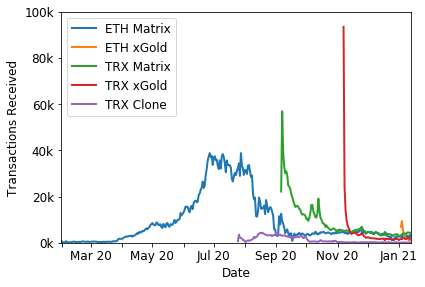

In [327]:
%matplotlib inline
def zero_nan_else_num(items):
    return [float('nan') if val==0 else val for val in items]
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import OrderedDict

forsage_count_od = OrderedDict(sorted(forsage_count_d.items(), key=lambda t: t[0]))
xgold_forsage_count_od = OrderedDict(sorted(xgold_forsage_count_d.items(), key=lambda t: t[0]))
total_per_day_od = OrderedDict(sorted(total_per_day.items(), key=lambda t: t[0]))
xtron_count_od = OrderedDict(sorted(xtron_count.items(), key=lambda t: t[0]))
xtron_scam_count_od = OrderedDict(sorted(xtron_scam_count.items(), key=lambda t: t[0]))
xtron_xgold_count_od = OrderedDict(sorted(xtron_xgold_count.items(), key=lambda t: t[0]))

myFmt = mdates.DateFormatter('%b %y')

# Create some mock data
t = list(forsage_count_od.keys())
data1 = zero_nan_else_num(list(forsage_count_od.values()))
data1b = zero_nan_else_num(list(xgold_forsage_count_od.values()))
data_tron_standard = zero_nan_else_num(list(xtron_count_od.values()))
data_tron_scam = zero_nan_else_num(list(xtron_scam_count_od.values()))
data_tron_xgold = zero_nan_else_num(list(xtron_xgold_count_od.values()))

data3 = list(total_per_day.values())

fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('Transactions Received')#, color=color)
ln1 = ax1.plot(t, data1, label='ETH Matrix', linewidth=2)
ln2 = ax1.plot(t, data1b, label='ETH xGold', linewidth=2)
ln3 = ax1.plot(t, data_tron_standard, label='TRX Matrix', linewidth=2)
ln4 = ax1.plot(t, data_tron_xgold, label='TRX xGold', linewidth=2)
ln5 = ax1.plot(t, data_tron_scam, label='TRX Clone', linewidth=2)
#ln6 = ax1.plot(t, data3, label='Daily Total', linewidth=2, alpha=0.6)
ax1.tick_params(axis='y')

ax1.relim()
ax1.autoscale()
ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(mdates.MonthLocator())

lns = ln1+ln2+ln3+ln4+ln5#+ln6
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

plt.margins(x=0, y=0)

plt.rcParams.update({'font.size': 12})
fig.tight_layout() 
for label in ax1.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.tight_layout()

labels = [item.get_text() for item in fig.axes[0].get_yticklabels()]
new_labels = []
for l in labels:
    if l == '': continue
    _l = str(int(int(l)/1000))+'k'
    new_labels.append(_l)
fig.axes[0].set_yticklabels(new_labels)
# fix xlabel 
fig.axes[0].set_ylabel("Transactions Received")
# refresh legend 
fig.axes[0].legend().texts 
# change font size
# matplotlib.rcParams.update({'font.size': 10})
size = 12
plt.rcParams.update({'font.size': size})#, 'axes.labelsize': size})
fig.axes[0].xaxis.label.set_size(size)
fig.axes[0].yaxis.label.set_size(size)

fig.axes[0].tick_params(axis='x', labelsize=size)
fig.axes[0].tick_params(axis='y', labelsize=size)

plt.ylim(0, 100000)

#plt.show()
plt.savefig('test.pdf')